
# Лабораторная работа №3

**Цель:** реализовать и сравнить три метода оптимизации для минимизации функции Розенброка:
- Метод тяжёлого шарика
- Ускоренный градиент Нестерова
- Метод SR1

**Функция Розенброка:**

$$
f(x, y) = 100(y - x^2)^2 + (1 - x)^2
$$

**Критерий останова:**

$$
|f(x_{k+1}) - f(x_k)| \leq 10^{-3}
$$

**Начальное приближение:**  
Случайная точка $ x_0 \in [-5, 5]^2 $ генерируется при помощи `random_state = 42`.


Было выбрано 3 метода минимизации:
- Метод Нестерова
- Метод тяжёлого шарика
- Метод SR1

## Импортируем Библиотечки

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.3,
    'axes.facecolor': '#f5f5f5',
    'axes.edgecolor': '0.4'
})

In [18]:
alpha_hb = 1e-4
beta_hb = 0.7

alpha_nest = 1e-4
beta_nest = 0.7

##  Функция Розенброка

In [19]:
def rosenbrock(x):
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

## 🧮 Градиент функции

**Градиент** — это вектор, содержащий частные производные функции по каждой из её переменных. Он указывает направление наискорейшего возрастания функции.

Для функции $f(x, y)$ градиент обозначается как:

$$
\nabla f(x, y) = \left[ \frac{\partial f}{\partial x}, \frac{\partial f}{\partial y} \right]
$$

---

### 🔍 Градиент функции Розенброка

Рассматриваем функцию:

$$
f(x, y) = 100(y - x^2)^2 + (1 - x)^2
$$

Частные производные:

- По переменной $ x $:
$$
\frac{\partial f}{\partial x} = -2(1 - x) - 400x(y - x^2)
$$

- По переменной $ y $:
$$
\frac{\partial f}{\partial y} = 200(y - x^2)
$$

---

Таким образом, градиент функции Розенброка:

$$
\nabla f(x, y) =
\begin{bmatrix}
-2(1 - x) - 400x(y - x^2) \\
200(y - x^2)
\end{bmatrix}
$$

Этот вектор вычисляется на каждом шаге оптимизации и используется для корректировки направления поиска минимума.


Вычисляем градиент функции Розенброка

In [20]:
def grad_rosenbrock(x):
    dx = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
    dy = 200 * (x[1] - x[0]**2)
    return np.array([dx, dy])

# Генерация начальной точки

In [21]:
np.random.seed(42)
x0 = np.random.uniform(-5, 5, size=2)

# Параметры остановки и максимум итераций

In [22]:
tol = 1e-3
max_iter = 10000

## ⚙️ Метод тяжёлого шарика (Heavy Ball Method)

**Метод тяжёлого шарика** — это градиентный метод оптимизации, модифицированный добавлением "инерционного" члена.
Он имитирует движение материальной точки (шарика), катящейся по поверхности графика функции, с учетом инерции.

---

### 📌 Идея метода

В отличие от обычного градиентного спуска:

$$
x_{k+1} = x_k - \alpha \nabla f(x_k)
$$

в методе тяжёлого шарика используется **две предыдущие точки** и добавляется "ускорение" (память о движении):

$$
x_{k+1} = x_k - \alpha \nabla f(x_k) + \beta (x_k - x_{k-1})
$$

где:

$ \alpha > 0 $ — шаг градиентного спуска, $ \beta \in [0, 1) $ — коэффициент инерции

---

### 💡 Физическая интерпретация

Метод моделирует движение точки с массой по графику функции:
$ \nabla f(x_k) $ — сила, действующая на шарик (градиент функции)
$ \beta (x_k - x_{k-1}) $ — инерция, сохраняющая направление движения

Такой подход помогает преодолевать "плоские участки" или узкие долины, ускоряя схождение.

---

### 📈 Применение к функции Розенброка

- Градиент $ \nabla f(x_k) $ используется как сила, тянущая вниз по направлению уменьшения функции.
- Инерция сглаживает движение и позволяет избежать "залипания" в негладких долинах.
- Однако метод может демонстрировать **осцилляции**, особенно при слишком большом значении $ \beta $

---

Метод тяжёлого шарика — это компромисс между:
- стабильностью градиентного спуска
- и ускорением за счёт накопления импульса.


In [23]:
def heavy_ball_method(x0, alpha=alpha_hb, beta=beta_hb):
    x_prev = x0.copy()
    x_curr = x0.copy()
    values = [rosenbrock(x_curr)]
    grad_evals = 0
    for i in range(max_iter):
        grad = grad_rosenbrock(x_curr)
        grad_evals += 1
        if i == 0:
            x_new = x_curr - alpha * grad
        else:
            x_new = x_curr - alpha * grad + beta * (x_curr - x_prev)
        values.append(rosenbrock(x_new))
        if abs(values[-1] - values[-2]) <= tol:
            break
        x_prev, x_curr = x_curr, x_new
    return x_curr, values, i+1, grad_evals

# 2. Ускоренный градиент Нестерова

## 🚀 Ускоренный градиентный метод Нестерова

**Метод Нестерова** (Nesterov Accelerated Gradient, NAG) — это модифицированный градиентный метод, в котором направление спуска рассчитывается не в текущей точке, а в "предсказанной" точке, куда алгоритм "движется".

Он обладает более высокой скоростью сходимости по сравнению с классическим градиентным спуском и широко используется в задачах машинного обучения и оптимизации негладких функций.

---

### 📌 Идея метода

Обычный градиентный спуск:

$$
x_{k+1} = x_k - \alpha \nabla f(x_k)
$$

Метод Нестерова вводит "опережающее" значение:

$$
y_k = x_k + \beta (x_k - x_{k-1})
$$

а затем использует градиент в точке $ y_k $:

$$
x_{k+1} = y_k - \alpha \nabla f(y_k)
$$

где:
- $ \alpha > 0 $ — шаг обучения (learning rate)
- $ \beta \in [0,1) $ — коэффициент инерции

---

### 💡 В чём отличие от метода тяжёлого шарика?

- Метод тяжёлого шарика использует градиент в текущей точке $ x_k $, а затем добавляет инерцию.
- Метод Нестерова сначала "смотрит вперёд" (в точку $ y_k $), а затем **корректирует движение** на основе градиента в этой точке.

Это позволяет **предугадывать будущее направление** функции и избегать лишнего "перелёта" через минимум.

---

### 📈 Применение к функции Розенброка

Для функции:

$$
f(x, y) = 100(y - x^2)^2 + (1 - x)^2
$$

на каждом шаге:
1. Строим точку $ y_k $
2. Вычисляем $ \nabla f(y_k) $
3. Двигаемся по этому направлению с шагом $ \alpha $

---

### ⚖️ Плюсы метода Нестерова

- Более **плавная** и **устойчивая** сходимость
- Меньше осцилляций, чем у метода тяжёлого шарика
- Эффективен для **узких долин**, таких как у функции Розенброка

---

Метод Нестерова — один из лучших ускоренных методов первого порядка, сочетающий **инерцию** и **предсказание направления**.


In [24]:
def nesterov_method(x0, alpha=alpha_nest, beta=beta_nest):
    x_prev = x0.copy()
    y = x0.copy()
    values = [rosenbrock(x0)]
    grad_evals = 0
    for i in range(max_iter):
        grad = grad_rosenbrock(y)
        grad_evals += 1
        x_new = y - alpha * grad
        values.append(rosenbrock(x_new))
        if abs(values[-1] - values[-2]) <= tol:
            break
        y = x_new + beta * (x_new - x_prev)
        x_prev = x_new
    return x_new, values, i+1, grad_evals

# 3. Метод SR1


## 🧮 Метод SR1

**Метод SR1** — это квазиньютоновский численный метод оптимизации, который использует градиенты функции и приближённую матрицу обратного гессиана, обновляемую на каждой итерации с помощью формулы SR1.

Он обладает хорошей сходимостью и не требует вычисления или обращения матрицы гессиана на каждом шаге, что снижает вычислительные затраты по сравнению с классическим методом Ньютона.

---

### 📌 Идея метода

На каждом шаге оптимизации выполняется обновление точки по правилу:

$$
x_{k+1} = x_k - B_k \nabla f(x_k)
$$

где:
- $ \nabla f(x_k) $ — градиент функции в точке $ x_k $
- $ B(x_k) $ — приближение обратного гессиана функции в точке $ x_k $, которое обновляется по формуле SR1.

---

### ⚙️ Обновление матрицы обратного гессиана $ B_k $


Чтобы приближать обратный гессиан без его прямого вычисления, используется формула обновления SR1:

$$
B_{k+1} = B_k + \frac{(s_k - B_ky_k)(s_k - B_ky_k)^T}{(s_k - B_ky_k)^T y_k}
$$

где:

$$ s_k = x_{k+1} - x_k,\;\;\; y_k = \nabla f(x_{k+1}) - \nabla f(x_k) $$

Обновление выполняется при условии, что знаменатель $ (s_k - B_kt_k)^T y_k $ не близок к нулю, чтобы избежать численных проблем.

---

### 📈Гессиан функции Розенброка

Для функции:

$$ f(x, y) = 100(y - x^2)^2 + (1 - x)^2 $$

градиент и гессиан известны и могут быть вычислены явно, однако в методе SR1 используется только градиент и обновляемое приближение обратного гессиана, что снижает вычислительные затраты.

\\

Таким образом, метод SR1 сочетает в себе:
* Использование градиентов для направления спуска
* Итеративное построение приближения обратного гессиана
* Эффективность и ускорение сходимости по сравнению с классическим градиентным методом
* Уменьшение затрат на вычисление и обращение матрицы гессиана.

### Реализуем метод SR1


In [25]:
def golden_section_search(f, x, p, a=0, b=1, tol_gs=1e-4, max_iter_gs=30):
        phi = (1 + 5 ** 0.5) / 2
        c = b - (b - a) / phi
        d = a + (b - a) / phi
        for _ in range(max_iter_gs):
            if f(x + c * p) < f(x + d * p):
                b = d
            else:
                a = c
            c = b - (b - a) / phi
            d = a + (b - a) / phi
            if abs(b - a) < tol_gs:
                break
        return (b + a) / 2

In [26]:
def sr1_method(x0, tol=1e-3, max_iter=10000, reg=1e-4, max_line_search_iter=30):
    n = len(x0)
    x_curr = x0.copy()
    B_inv = np.eye(n)
    values = [rosenbrock(x_curr)]
    grad_curr = grad_rosenbrock(x_curr)
    grad_evals = 1

    for i in range(max_iter):
        p = - B_inv @ grad_curr

        func_lambda = lambda l: rosenbrock(x_curr + l * p)
        lambda_opt = golden_section_search(func_lambda, x_curr, p, a=0, b=1)

        x_new = x_curr + lambda_opt * p
        grad_new = grad_rosenbrock(x_new)
        grad_evals += 1

        s = x_new - x_curr
        y = grad_new - grad_curr
        Bs = B_inv @ y
        diff = s - Bs

        denom = diff @ y
        if abs(denom) > 1e-8:
            B_inv += np.outer(diff, diff) / denom

        values.append(rosenbrock(x_new))

        if abs(values[-1] - values[-2]) <= tol:
            break

        x_curr = x_new
        grad_curr = grad_new

    return x_curr, values, i+1, grad_evals

# Графики

In [27]:
hb_x, hb_vals, hb_iters, hb_grads = heavy_ball_method(x0)
nesterov_x, nesterov_vals, nesterov_iters, nesterov_grads = nesterov_method(x0)
sr1_x, sr1_vals, sr1_iters, sr1_grads = sr1_method(x0)

In [28]:
print("Метод тяжёлого шарика:")
print(f"  Итераций: {hb_iters}, Значение функции: {hb_vals[-1]:.5f}")
print("Ускоренный градиент Нестерова:")
print(f"  Итераций: {nesterov_iters}, Значение функции: {nesterov_vals[-1]:.5f}")
print("Метод SR1:")
print(f"  SR1: итераций {sr1_iters}, Значение функции = {sr1_vals[-1]:.5f}")

Метод тяжёлого шарика:
  Итераций: 34, Значение функции: 9.18277
Ускоренный градиент Нестерова:
  Итераций: 16, Значение функции: 9.26813
Метод SR1:
  SR1: итераций 7, Значение функции = 8.65066


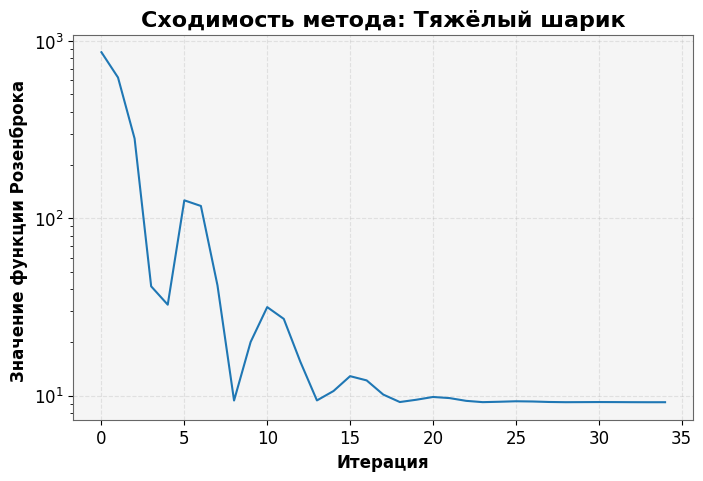

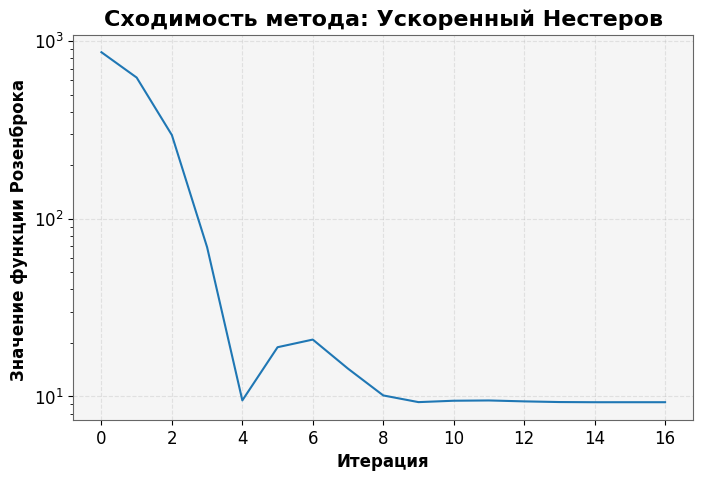

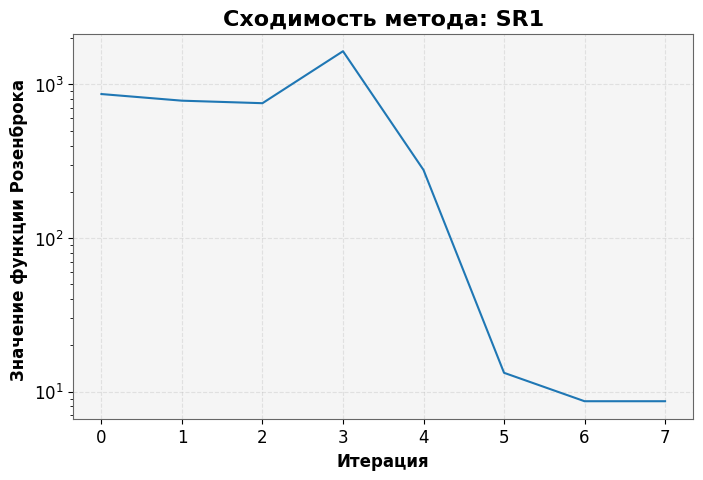

In [29]:
def plot_values(values, method_name):
    plt.figure(figsize=(8,5))
    plt.plot(values)
    plt.yscale('log')
    plt.xlabel("Итерация")
    plt.ylabel("Значение функции Розенброка ")
    plt.title(f"Сходимость метода: {method_name}")
    plt.grid(True)
    plt.show()

plot_values(hb_vals, "Тяжёлый шарик")
plot_values(nesterov_vals, "Ускоренный Нестеров")
plot_values(sr1_vals, "SR1")


# 📊 Сравнительная таблица результатов



In [30]:
data = {
    'Метод': ['Тяжёлый шарик', 'Ускоренный Нестеров', 'SR1'],
    'Число итераций': [hb_iters, nesterov_iters, sr1_iters],
    'Число вычислений градиента': [hb_grads, nesterov_grads, sr1_grads],
    'Число вычислений гессиана': [0, 0, 1],
    'Значение функции': [hb_vals[-1], nesterov_vals[-1], sr1_vals[-1]]
}
df = pd.DataFrame(data)

In [31]:
df

,Метод,Число итераций,Число вычислений градиента,Число вычислений гессиана,Значение функции
0,Тяжёлый шарик,34,34,0,9.182773
1,Ускоренный Нестеров,16,16,0,9.268131
2,SR1,7,8,1,8.650664



## 💬 Выводы

- **Метод SR1** показывает хороший компромисс между скоростью сходимости и стабильностью, эффективно приближая гессиан и улучшая качество поиска минимума.
- **Метод тяжёлого шарика** демонстрирует осцилляции в начале, затем плавное, но медленное схождение.
- **Метод Нестерова** сочетает устойчивость и скорость, демонстрируя наилучшее поведение среди трёх методов.
